## Translating DBpedia queries to Wikidata with LLMs

In [ ]:
# import all the necessary libraries
import re
import json
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

Create dataset for asking the LLMs

In [7]:
# Load the dataset from 100_complete_entries.json
with open("100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia
    
    # Extract entities and relations (ER2) in Wikidata
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["wikidata_ids"]  # Only include non-empty Wikidata mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset.json'.")

Processed dataset saved to 'llm_input_dataset.json'.


## Creating second version of llm input dataset
This version includes an output template in the instruction in order to make it easier to extract the final SPARQL query from the output of the LLMs.

In [8]:
# Load the dataset from 100_complete_entries.json
with open("100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia
    
    # Extract entities and relations (ER2) in Wikidata
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["wikidata_ids"]  # Only include non-empty Wikidata mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2. In your answer please hightlight the final, complete SPARQL query within the tags <sparql> and </sparql>."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset_template.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset_template.json'.")

Processed dataset saved to 'llm_input_dataset_template.json'.


## First test with 10 sample queries
Using meta-llama-3.1-8b-instruct for the first test of translating the queries from DBpedia to Wikidata. The connection works and the model is able to translate the queries. The output is quite large, because the model also explains what as been done. Should the prompt be changed to get a more concise output, only the complete query?

**meta-llama-3.1-8b-instruct is the smallest available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 8billion parameters**

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Limit to the first 10 queries
limited_input_data = llm_input_data[:10]

# Query the LLM for each entry in the limited dataset
for entry in limited_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_10_queries_meta-llama-3.1-8b.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for 10 questions saved to 'translated_llm_output_10_queries_meta-llama-3.1-8b.json'.")

Translated SPARQL queries for 10 questions saved to 'translated_llm_output_10_queries.json'.


## Test for Mistral-Large-Instruct 
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"  # Updated to use the new model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Limit to the first 10 queries
limited_input_data = llm_input_data[:10]

# Query the LLM for each entry in the limited dataset
for entry in limited_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_10_queries_mistral.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for 10 questions saved to 'translated_llm_output_10_queries_mistral.json'.")

Translated SPARQL queries for 10 questions saved to 'translated_llm_output_10_queries_mistral.json'.


## Testing meta-llama-3.1-8b-instruct with 100 queries

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b.json'.


## Testing Mistral-Large-instruct with 100 queries

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral.json'.


## Testing meta-llama-3.1-8b-instruct with 100 queries and the updated query template

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_template.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b_template.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_template.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_template.json'.


## Testing Mistral-Large-instruct with 100 queries and the updated query template

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_template.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral_template.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_template.json'.")


Error querying LLM for question ID What is the alma mater of the chancellor of Germany Angela Merkel?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': '5123895c32290a294e6b6d54c3a85b52'}
Error querying LLM for question ID Who created Goofy?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': '4addf6380917171023864136e8287f11'}
Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_template.json'.


## Analysis of the results
For now it can be seen that the extraction process for the larger model (mistral-large-instruct) is working better than for the smaller model (meta-llama-3.1-8b-instruct). The output of the smaller model is not that structured making it harder to extract the queries. On the first sight it also seems that the queries from the larger model are working better.


Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [ ]:
# Load the input JSON file
file_path = "translated_llm_output_mistral.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract SPARQL query from the `sparql_query_kg2` field and remove comments
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "")
    # Remove comments starting with `#` and clean up spaces
    cleaned_query = re.sub(r"#.*", "", raw_query)  # Remove everything after `#` on each line
    # Extract content between SPARQL code blocks (```sparql and ``` or similar markers)
    match = re.search(r"```sparql\n(.*?)\n```", cleaned_query, re.DOTALL)
    if match:
        return match.group(1).replace("\n", " ").strip()  # Remove newline characters and trim whitespace
    return None

# Extract SPARQL queries
queries_with_context = []
for entry in data:
    sparql_query = extract_sparql_query(entry)
    if sparql_query:
        queries_with_context.append({
            "natural_language_question": entry["context"]["natural_language_question"],
            "sparql_query_kg2": sparql_query
        })

# Save the extracted queries to a new JSON file
output_file = "mistral_wiki_trans_sparql_queries.json"
with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

print(f"Cleaned and extracted data has been saved to {output_file}.")


Cleaned and extracted data has been saved to mistral_wiki_trans_sparql_queries.json.


Extracting the SPARQL queries from LLM output for **lama-3.1-8b-instruct**.

In [14]:
input_file_path = 'translated_llm_output_meta-llama-3.1-8b.json'
output_file_path = 'lama_wiki_trans_sparql_queries.json'

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        # Match SPARQL code blocks or queries starting with SPARQL keywords
        sparql_match = re.search(r"```sparql\s*(.*?)\s*```|PREFIX.*?WHERE\s*\{.*?\}", sparql_raw, re.DOTALL)
        if sparql_match:
            # Extract the matched SPARQL query
            query = sparql_match.group(1) or sparql_match.group(0)
            # Clean query by removing comments and excessive whitespace
            query = re.sub(r"#.*", "", query)  # Remove comments
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace and newlines
            # Remove surrounding ```sparql and ```
            query = query.replace("```sparql", "").replace("```", "").strip()
            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    return None

# Process all entries and keep natural language question with the query
result = []
for entry in data:  # Process all entries
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })

# Save the cleaned and extracted data to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

print(f"Cleaned and extracted data has been saved to {output_file_path}.")


Cleaned and extracted data has been saved to lama_wiki_trans_sparql_queries.json.


## Run the extracted SPARQL queries on Wikidata
Results for **mistral-large-instruct**.

5 Queries are not working, because the syntax is not correct, probably because the extraction process did not work accuratly. Could probably be fixed by manual adjustments. 

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix wikibase was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 263,\n        "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/>  SELECT DISTINCT ?mountain ?mountainLabel ?elevation WHERE {   ?mountain wdt:P31 wd:Q8502 ;             wdt:P131 wd:Q38 ;             wdt:P2044 ?elevation .   SERVICE wikibase:label { bd:serviceParam wikibase:language \\"[AUTO_LANGUAGE],en\\". } } ORDER BY DESC(?elevation) LIMIT 1",\n        "startIndex": 263,\n        "stopIndex": 276\n    },\n    "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/>  SELECT DISTINCT ?mountain ?mountainLabel ?elevation WHERE {   ?mountain wdt:P31 wd:Q8502 ;             wdt:P131 wd:Q3

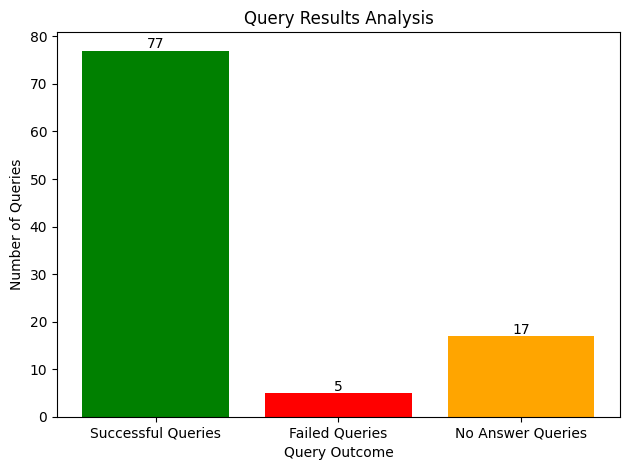

In [ ]:
# File paths
input_file_path = "mistral_wiki_trans_sparql_queries.json"
output_file_path = "wikidata_query_results_mistral.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

## Further steps
- Test the results for lama-3.1-8b-instruct 
- Compare both results
- Compare the answers if the are matching with the original dataset
- Test the results for mistral-large-instruct and lama-3.1-8b-instruct with the new query template and see if its easier to extract the queries and more accurate